#APOGEE Data:  "Zero to Hero"
TODO Add TOC
[Description](#Description)

Description
=============

### What this is

  An exectuable, interactive Ipython Notebook designed to quickly get
  novices up and running with APOGEE data. By the end of this tutorial,
  you will be able to :
  - Download the APOGEE Summary file
  - Read the APOGEE Summary file into memory
  - Define "clean" samples by making cuts on tageting and reduction
    flags
  - Make exciting plots of APOGEE data

  Along the way, you will also learn more about the APOGEE data model
  and bitmasks.


### What this isn't

  A comprehensive guide to the APOGEE survey and data products. Please
  see the official APOGEE documenation at
  [http://www.sdss.org/dr12/irspec/] for a more through understanding of
  the APOGEE database. Below, we provide links to this documentation
  where appropriate. [http://www.sdss.org/dr12/irspec/catalogs/] is the
  best place to start further educating yourself about APOGEE
  parameters. [Official papers?]




Sources/Thanks
================

  The material herein is a result of the whole APOGEE team.


Requirements
==============

  This tutorial is written in Python 2.7. Python 3+ *should* work with
  minimal effort from the user. Additional python modules required:
  - numpy
  - pyfits
  - matplotlib

  This notebook will likely still be valuable to you, but less so, if
  you are using a language other than python. There are official data
  exploration examples using the CAS database, IDL, or python at
  [http://www.sdss.org/dr12/irspec/catalogs/#ExamplesofselectingAPOGEEdatafromcatalogs]
  .



4 The Summary File
==================

  The APOGEE *allStar* summary file is one of two APOGEE [parameter catalogs](http://www.sdss.org/dr12/irspec/catalogs/) available as FITS tables. The entire summary parameter catalog is less than 1 GB in size, making it very portable and easy to access.
  The allStar file 
  >provides
  >information for each individual star observed in APOGEE-1, which
  >includes mean barycentric radial velocity, the standard deviation of
  >the mean velocity, ASPCAP parameters and abundances as derived from
  >the combined spectra, and a compilation of ancillary targeting data.
  
  >-[APOGEE official documentation](http://www.sdss.org/dr12/irspec/catalogs/)

  The latest, official Data Release from SDSS is DR12. The APOGEE summary
  file for this release is named 'allStar-v603.fits' (~683 MB). The rest of this tutorial will focus on interacting with this catalog.




5 Getting the Data
==================

  **Option 1**: Directly download the allStar file [here](http://data.sdss3.org/sas/dr12/apogee/spectro/redux/r5/allStar-v603.fits). Once the catalog is downloaded, move the file  into the path assigned to the `data_directory` variable in Section 6.2. The catalog is large (~683 MB) so it might be best to download the catalog first and then finish the tutorial.
  
  **Option 2**: Automatic Download. As you run the code, it will search for the *allStar-v603.fits* file in the path assigned to `data_directory`. If it is not found, the catalog will be downloaded.

##6 Loading the *allStar* Summary File

### 6.1 Python Preamble 
You need to press `Shift+Enter` to execute the code cells below. The preamble just contains some useful modules, functions, and plot formatting snippets. 

In [1]:
from __future__ import print_function
import numpy as np
import os
import sys
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

###Plot formatting commands
plt.rc('figure', figsize=(10.0, 7.1)) #bigger figures
plt.rc('xtick', labelsize=14)  #bigger labels
plt.rc('ytick', labelsize=14)
###End formatting commands


#Progress bar function for automatic download
from IPython.display import clear_output   #function to clear cell output
def report(count, blockSize, totalSize):   #function to report download percentage
    percent = int(count*blockSize*100/totalSize)
    clear_output()
    print('{}% complete\r'.format(percent))
    sys.stdout.flush()
    
### Functions for automatic downloading of catalog
import urllib  
### Checking for python 2 or 3
if sys.version_info > (3,0): # If python3
    geturl_func = urllib.request.urlretrieve
else: #python2
    geturl_func = urllib.urlretrieve

### 6.2 APOGEE Data Path

   <span style="color:red">**MAKE SURE TO DEFINE YOUR DATA PATH in the next cell**</span>

  The `data_directory` variable is the diretory where your summary
  file is located OR where you want the summary file downloaded. Make sure this
  path exists on your local machine.

In [2]:
data_directory = "/hd1/obs_data/apogee/"  #### CHANGE THIS PATH

if not os.path.exists(data_directory):
    print("\nMake sure the data_directory path exists!\n")
else:
    print("Your APOGEE data directory is: {}\nWoohoo! Let's get started!".format(data_directory))


Your APOGEE data directory is: /hd1/obs_data/apogee/
Woohoo! Let's get started!


### 6.3 Reading the allStar File

The *allStar* file is a FITS table, a common astronomical data format. To read it off disk and into memory, we will use the popular [astropy](http://www.astropy.org/) package which includes the latest version of `pyfits` FITS reader. The code below will first try to use `astropy` but will automatically fall back to `pyfits` if `astropy` is not installed. At least one of these packages must be installed to continue. Note that  [pyfits](http://www.stsci.edu/institute/software_hardware/pyfits) is the precursor to the `astropy.io.fits` package.

In [3]:
try:
    import astropy.io.fits as pyfits
except ImportError:
    import pyfits

allStar_file = 'allStar-v603.fits'
allStar_localpath = os.path.join(data_directory,allStar_file)

allStar_file_link = "http://data.sdss3.org/sas/dr12/apogee/spectro/redux/r5/allStar-v603.fits"

#Download allStar file if it does not exist (This will take a while!)
if not os.path.exists(allStar_localpath):
    geturl_func(allStar_file_link, filename=allStar_localpath, reporthook=report)

allStar_fits = pyfits.open(allStar_localpath)
allStar = allStar_fits[1].data #Takes data is HDU 1 and assigns it to allStar

### 6.4 APOGEE *allStar* catalog as python variable


  The allStar variable is now a numpy
  record array, a wrapper around [numpy.ndarray](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html). The total number of stars in the catalog is equal to the number of rows in the table. Check the number of rows with 



In [4]:
allStar.shape

(163278,)

and the available data fields (This will print out every data field name in the `allStar` file)

In [5]:
allStar.dtype.fields

<dictproxy {'AK_TARG': (dtype('>f4'), 2005),
 'AK_TARG_METHOD': (dtype('S17'), 2009),
 'AK_WISE': (dtype('>f4'), 2026),
 'ALL_VISITS': (dtype('S737'), 2066),
 'ALL_VISIT_PK': (dtype(('>i4', (50,))), 3468),
 'AL_H': (dtype('>f4'), 1603),
 'AL_H_ERR': (dtype('>f4'), 1663),
 'AL_H_FLAG': (dtype('>i4'), 1723),
 'ANDFLAG': (dtype('>i4'), 524),
 'ANDFLAGS': (dtype('S59'), 528),
 'APOGEE_ID': (dtype('S18'), 157),
 'APOGEE_TARGET1': (dtype('>i4'), 257),
 'APOGEE_TARGET2': (dtype('>i4'), 261),
 'APSTAR_ID': (dtype('S45'), 0),
 'APSTAR_VERSION': (dtype('S5'), 675),
 'ASPCAPFLAG': (dtype('>i4'), 1418),
 'ASPCAPFLAGS': (dtype('S153'), 1422),
 'ASPCAP_CHI2': (dtype('>f4'), 1412),
 'ASPCAP_CLASS': (dtype('S2'), 1416),
 'ASPCAP_ID': (dtype('S44'), 79),
 'ASPCAP_VERSION': (dtype('S6'), 680),
 'CA_H': (dtype('>f4'), 1607),
 'CA_H_ERR': (dtype('>f4'), 1667),
 'CA_H_FLAG': (dtype('>i4'), 1727),
 'CHI2_THRESHOLD': (dtype(('>f4', (2,))), 659),
 'COMMISS': (dtype('>i2'), 385),
 'C_H': (dtype('>f4'), 1611),


7 *allStar* Data Model
=================================

A lot of your interaction with the APOGEE catalog will be through pulling out the information that interests you from the `allStar` file. It's a good idea to familiarize yourself with the catalog's contents.

The APOGEE team provides a full description of the *allStar* file via the [data model](http://data.sdss3.org/datamodel/files/APOGEE_REDUX/APRED_VERS/APSTAR_VERS/ASPCAP_VERS/RESULTS_VERS/allStar.html). Some details, like the size of the catalog on disk, will likely be different than v603 (the version you downloaded).
 
 A non-exhaustive list of important fields (some of which we will use below):

| Field          | dtype    | units     | description                                                                                                                             |
| ---            | ----     | ----      | ----                                                                                                                                    |
| APSTAR_ID      | char[37] |           | Unique apStar identifier: apogee.[ns].[sc].APSTAR_VERS.LOC.STAR, where [ns] is for APOGEE North/South, [sc] is for survey/commissioning |
| ASPCAP_ID      | char[36] |           | Unique ASPCAP identifier: apogee.[ns].[sc].RESULTS_VERS.LOC.STAR                                                                        |
| APOGEE_ID      | char[18] |           | TMASS-STYLE object name                                                                                                                 |
| J              | float32  |           | 2MASS J mag                                                                                                                             |
| H              | float32  |           | 2MASS H mag                                                                                                                             |
| K              | float32  |           | 2MASS Ks                                                                                                                                |
| GLON           | float64  | degrees   | Galactic                                                                                                                                |
| GLAT           | float64  | degrees   | Galactic                                                                                                                                |
| AK_TARG        | float32  |           | K-band extinction adopted for                                                                                                           |
| APOGEE_TARGET1 | int32    |           | first APOGEE target flag, see bitmask definitions                                                                                       |
| APOGEE_TARGET2 | int32    |           | second APOGEE target flag, see bitmask                                                                                                  |
| COMMISS        | int16    |           | =1 for commissioning data (before July 2011), else 0                                                                                    |
| SNR            | float32  |           | median S/N per pixel in combined frame (at apStar sampling                                                                              |
| STARFLAG       | int32    |           | Flag for star condition taken from bitwise OR of individual visits, see bitmask                                                         |
| VHELIO_AVG     | float32  | km/s      | average radial velocity, weighted by S/N, using RVs determined from cross-correlation of individual spectra with combined               |
| VSCATTER       | float32  | km/s      | scatter of individual visit RVs around                                                                                                  |
| TEFF           | float32  | K         | Teff from ASPCAP analysis of combined spectrum (from PARAM)                                                                             |
| LOGG           | float32  | log (cgs) | log g from ASPCAP analysis of combined spectrum (from PARAM)                                                                            |
| METALS         | float32  | dex       | [Z/H] from ASPCAP analysis of combined spectrum (from PARAM)                                                                            |
| ALPHAFE        | float32  | dex       | [alpha/Fe] from ASPCAP analysis of combined spectrum (from PARAM)                                                                       |
| ASPCAPFLAG     | int32    |           | Flag for  ASPCAP analysis, see bitmask                                                                                                  |
| PARAMFLAG      | int32[7] |           | Individual parameter flag for ASPCAP analysis, see bitmask                                                                              |


7.1 Sky map of the APOGEE Catalog
-----------------------------------

  Now that you have loaded the catalog, we can make our first plot! Let's make a sky map of the APOGEE catalog.

  - Maybe mention Kepler field here
  - Need to ask Gail about her plots



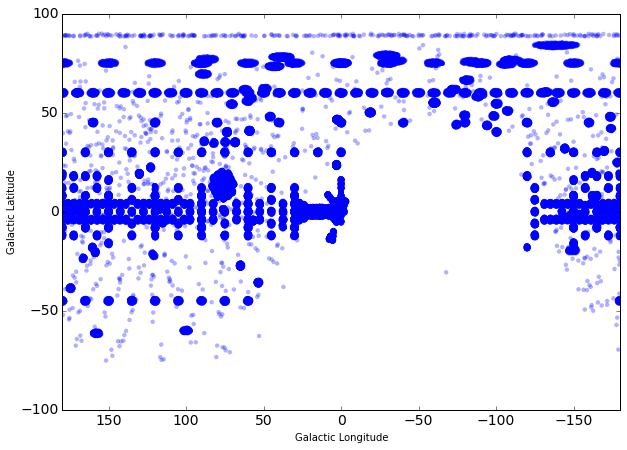

In [6]:
fig =plt.figure()
ax = plt.subplot(111) ## Ask Gail how she does the box around the projection, projection='mollweide') # set up projection
# For pretty plotting, make longitude negative relative to Galactic center.␣
l_corr_inds = allStar['GLON']>180 #indices for GLON correction
l_corr = allStar['GLON'].copy() # just to be safe,
l_corr[l_corr_inds] -=360
ax.scatter(l_corr, allStar['GLAT'], edgecolor='none', alpha=0.3)
ax.set_xlim(180,-180)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

8 Clean samples, Targeting / Reduction flags
============================================

  Before doing any science with APOGEE, you will likely want a "clean"
  sample of stars. APOGEE has many special types of targets (calibration
  clusters, commissioning data, etc.; you can read more about the types
  of targets HERE). Below, we assume that you are interested in the
  "main" survey targets (defined below).


### 8.1 A Quick Aside: Bitmasks


  If you are unfamiliar with bitmasks, SDSS has published a great
  primer: [http://www.sdss.org/dr12/algorithms/bitmasks]. In short,
  bitmasks provide an easy way to ask many True/False questions about an
  object without the need for independent variables. Let's look at a
  quick example.
  


In [7]:
allStar['APOGEE_TARGET1'][2]

-2147481600

Above is the APOGEE_TARGET1 bitmask for a single star. A
  full description of the available bits in APOGEE_TARGET1 is available
  at [http://www.sdss.org/dr12/algorithms/bitmasks/#APOGEE_TARGET1].

  Each bit in the bitmask above contains information about the target. Note that all valid APOGEE targets have the 31st bit set.

This object is part of a 'short' cohort (see Zasowski+ for
  description), so the 11th bit is also set. You can check the value of a particular bit using the bitwise `and` operator.

In [8]:
allStar['APOGEE_TARGET1'][2] & 2**11

2048

The result will be non-zero if the bit is set; otherwise it will be zero.

In [9]:
allStar['APOGEE_TARGET1'][2] & 2**15 #not set

0

Below, we will be using a series of cuts on the APOGEE bitmasks to define our
  "clean" sample. 

  Links to other APOGEE bitmasks that we will use can be found at:
  [http://www.sdss.org/dr12/algorithms/bitmasks/#APOGEE_TARGET2]
  [http://www.sdss.org/dr12/algorithms/bitmasks/#APOGEE_ASPCAPFLAG]



### Defining the "Main" Sample


  Main survey targets (excludes standards, known structure targets,
  e.g., cluster members, tarteged pointings) are members of a short,
  medium, or long cohort. The cohorts are defined by dereddened
  magnitude cuts (as described in Zasowski+ and at the APOGEE Targeting
  Information page [http://www.sdss.org/dr12/irspec/targets/]).

  Short, medium, and long cohort targets are desginated by bits 11,12,
  and 13 in APOGEE_TARGET1. Let's create a boolean mask that returns all
  stars that are in one of these cohort groups.

In [10]:
mainIndx = (allStar['APOGEE_TARGET1'] & 2**11 !=0) | (allStar['APOGEE_TARGET1'] & 2**12 != 0) | (allStar['APOGEE_TARGET1'] & 2**13 !=0)

`mainIndx` is now an array with the same shape as allStar whose elements
  are True IF the star is a short, medium, or long cohort star. 



In [11]:
mainIndx

array([False, False,  True, ...,  True,  True, False], dtype=bool)

Let's define a new variable to point towards all of the 'Main' targets in the APOGEE catalog.

In [12]:
mainStar = allStar[mainIndx]

9 Plot: The RV distribution of the inner galaxy
==========================================================

  Let's look at the line of sight velocity distribution for stars in the
  inner Galaxy.

First, spatially define the inner Galaxy. Here, let's pick all stars with
    -15 < $l$ < 15 and close to the plane of the disk: -5 < $b$ < 5.


In [13]:
inner_galaxy_mask = np.logical_or(mainStar['GLON']>345.0, mainStar['GLON']<15.0)  & (np.abs(mainStar['GLAT'])< 5)

 We can check for the number of stars that meet this criteria by asking
  for the sum of the mask (True=1 and False=0)

In [14]:
np.sum(inner_galaxy_mask)

10528

  Now let's look at the distribution of radial velocities for main
  survey targets towards the inner galaxy.

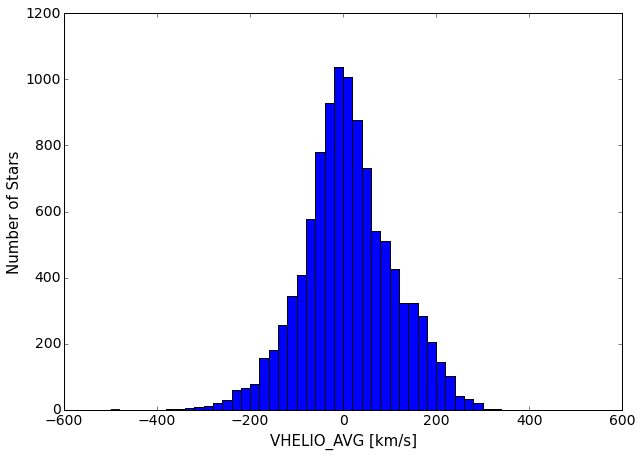

In [15]:
plt.hist(mainStar[inner_galaxy_mask]['VHELIO_AVG'], bins = np.arange(-500,500,20))
plt.xlabel('VHELIO_AVG [km/s]', fontsize=15)
plt.ylabel('Number of Stars', fontsize=15)



  Beautiful! We find a sharp peak at VHELIO_AVG~ 0 km/s because many
  stellar orbits are perpendicular to our line of sight when we look
  towards the Galactic center.


10 Galactic Plane Metallicity Maps
=========================
 

  This next plot is loosely based on the kinematics maps from Ness et al., in prep. (2015). Here we will map the metallicity of $l<180^{\circ}$ sightlines in the Galactic plane.

To group neighboring stars, the code below makes use of `hexbin` from the 
`matplotlib` library. From http://matplotlib.org/api/pyplot_api.html, `hexbin` will
  
>Make a hexagonal binning plot of x versus y, where x, y are 1-D sequenc
es of the same length, N. If C is None (the default), this is a histogram of
the number of occurences of the observations at (x[i],y[i]).
 


In [16]:
#define our zone of spatial interest
galactic_plane_mask = np.logical_and(mainStar['GLON']>0, mainStar['GLON']<180.0)  & (np.abs(mainStar['GLAT'])< 15)
planeSamp = mainStar[galactic_plane_mask] # all stars that are main targets and are in the 
#inner_galaxy mask we created earlier

#Correct for GLON
#GLON_plot = centralSamp['GLON'].copy()  # to ensure we don't modify GLON
#GLON_plot[GLON_plot>180] = GLON_plot[GLON_plot>180]-360

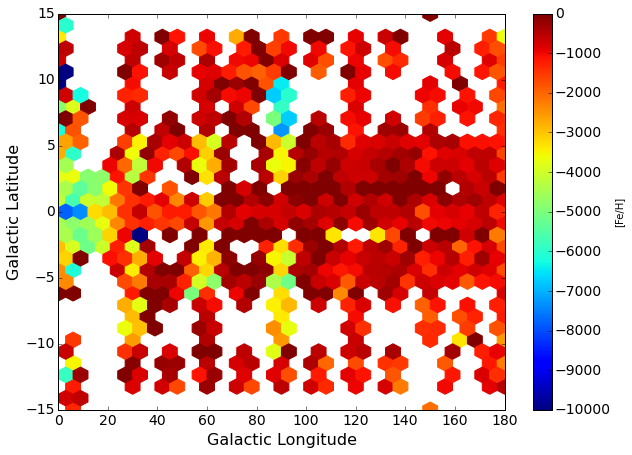

In [17]:
plt.hexbin(planeSamp['GLON'], planeSamp['GLAT'], C=planeSamp['FE_H'],
           reduce_C_function=np.mean, gridsize=30)
plt.xlabel('Galactic Longitude', fontsize=16)
plt.ylabel('Galactic Latitude', fontsize=16)
cb = plt.colorbar(label='[Fe/H]')
#Label Colorbar

The hexagons above are colored by the mean metallicity of all the stars that have the labeled Galactic longitude and latitude. **WHAT HAPPENED?** How could the mean metallicity of some regions be ~-10000? Before we publish our miraculously discovery, we should make sure that the reduction and ASPCAP pipeline does not report any errors for these stars. 

To makes sure our results are robust, we should only use stars that:

 - are non-commissioning data (`commision_mask`) via the 'COMMISS' data field of the allStar file.
 - do not cause errors in the general ASPCAP pipeline (`starbad_mask`) via the 'STAR_BAD' bit of the ASPCAPFLAG bitmask (detailed at http://www.sdss.org/dr12/algorithms/bitmasks/#APOGEE_ASPCAPFLAG)
 - had an error-free [Fe/H] abundance determination (`feh_mask`) via the 'GRIDEDGE_BAD', 'CALRANGE_BAD', and 'OTHER_BAD' bits in the individual element bitmask (detailed at bhttp://www.sdss.org/dr12/algorithms/bitmasks/#APOGEE_PARAMFLAG)



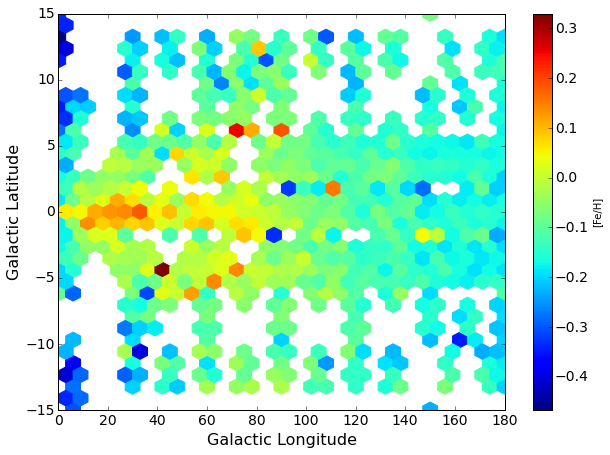

In [18]:
commission_mask = (mainStar['COMMISS']==0)
starbad_mask = (mainStar['ASPCAPFLAG'] & 2**23 ==0)
feh_mask = (mainStar['FE_H_FLAG'] & 2**0 ==0) & (mainStar['FE_H_FLAG'] & 2**1 ==0)& (mainStar['FE_H_FLAG'] & 2**2 ==0)

#Now sample is all inner_galaxy stars that ALSO meet the criteria above
cleanPlaneSamp = mainStar[galactic_plane_mask &  feh_mask & commission_mask & starbad_mask]

plt.hexbin(cleanPlaneSamp['GLON'], cleanPlaneSamp['GLAT'], C=cleanPlaneSamp['FE_H'],
           reduce_C_function=np.mean, gridsize=30)
plt.xlabel('Galactic Longitude', fontsize=16)
plt.ylabel('Galactic Latitude', fontsize=16)
cb = plt.colorbar(label='[Fe/H]')

Awesome! We now see the metallicity of the central region of the Galaxy as a function of position. **Comment on metallicity gradient**

# 11 Plot: Metallicity vs. RV for Quadrant 2 Stars

Once you get a feel for this workflow, you can quickly make plots using tens of thousands of stars. To make a plot showing the radial velocity and metallicity of all stars that are in quadrant 2, simply:

- Define the spatial region of interest
- Make sure the sample's [Fe/H] is 'clean' as we did for the Galactic plane sample above

In [19]:
#Quadrant 2 is 90 < GLON < 180
quadrant2 = (mainStar['GLON']>90) & (mainStar['GLON']<180)

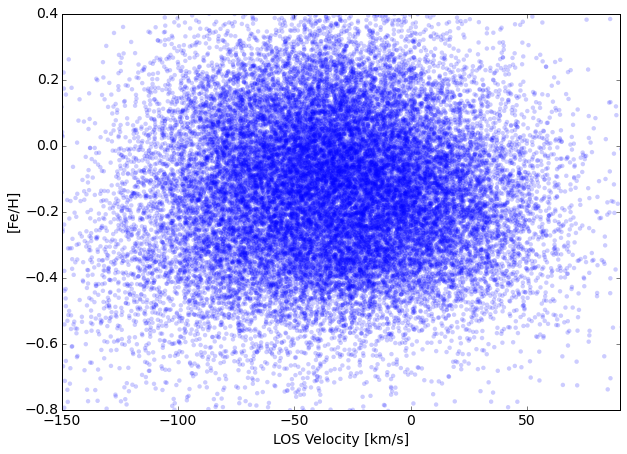

In [20]:
# The following 3 masks were already defined so they did NOT have to be recreated
# Doing so here in case people jump to this example
commission_mask = (mainStar['COMMISS']==0)
starbad_mask = (mainStar['ASPCAPFLAG'] & 2**23 ==0)
feh_mask = (mainStar['FE_H_FLAG'] & 2**0 ==0) & (mainStar['FE_H_FLAG'] & 2**1 ==0) & (mainStar['FE_H_FLAG'] & 2**2 ==0)

good_quadrant2 = mainStar[quadrant2 & starbad_mask & commission_mask & feh_mask]
plt.scatter(good_quadrant2['VHELIO_AVG'], good_quadrant2['FE_H'], edgecolor='none', alpha=0.2)
plt.xlim(-150,90)
plt.ylim(-0.8,0.4)
plt.xlabel('LOS Velocity [km/s]', fontsize=14)
plt.ylabel('[Fe/H]', fontsize=14)

# 12 The Red Clump Catalog

Description here Bovy+ . Distances! Because of distances, can make spatial map, similar to Nidever+ (2014). LINK and lots more info.

## 12.1 Getting the Data
  **Option 1**: Directly download the RC catalog file [here](http://data.sdss3.org/sas/dr12/apogee/vac/apogee-rc/cat/apogee-rc-DR12.fits). Once the catalog is downloaded, move the file  into the path assigned to the `data_directory` variable in Section 6.2.
  
  **Option 2**: Automatic Download. As you run the code, it will search for the *apogee-rc-DR12.fits* file in the path assigned to `data_directory`. If it is not found, the catalog will be downloaded.

## 12.1 Reading the RC Catalog

In [21]:
#Make sure the urllib module has been imported and geturl_func has been defined!

rc_file = 'apogee-rc-DR12.fits'
RCstar_localpath = os.path.join(data_directory,rc_file)

RCstar_file_link = 'http://data.sdss3.org/sas/dr12/apogee/vac/apogee-rc/cat/apogee-rc-DR12.fits'
#Download allStar file if it does not exist
if not os.path.exists(RCstar_localpath):
    geturl_func(RCstar_file_link, filename=RCstar_localpath, reporthook=report)

allRC_fits = pyfits.open(RCstar_localpath)
allRC = allRC_fits[1].data #Takes data is HDU 1 and assigns it to allStar

## 12.3 Red Clump Data Model

All available data for the Red Clump sample is described by the data model at http://data.sdss3.org/datamodel/files/APOGEE_RC/cat/apogee-rc-DR12.html.
Some interesting additional data fields available for RC stars:

| Field     | dtype | Units     |Description                                                |
|-----      |-----  | -----     |------------                                               |
|RC_DIST	|float64|	kpc 	|Distance                                                   |
|RC_DM	    |float64|	    	|Distance modulus                                           |
|RC_GALR	|float64|	kpc 	|Galactocentric distance assuming R0 = 8 kpc, Z0 = 25 pc    |
|RC_GALPHI	|float64|	radians	|Galactocentric azimuth assuming R0 = 8 kpc, Z0 = 25 pc     |
|RC_GALZ	|float64|	kpc 	|Distance from the mid-plane assuming R0 = 8 kpc, Z0 = 25 pc|




## 12.4 Plot: [$\alpha$/Fe] vs. [Fe/H] for annulus of stars
We can use the precise distances of RC stars to probe particular regions of the galaxy. For example, let's examine the [$\alpha$/Fe] vs. [Fe/H] plane for stars with $6 < R_{\mathrm{GC}} < 8$ kpc and $|z_{\mathrm{GC}}| < 1$ kpc.

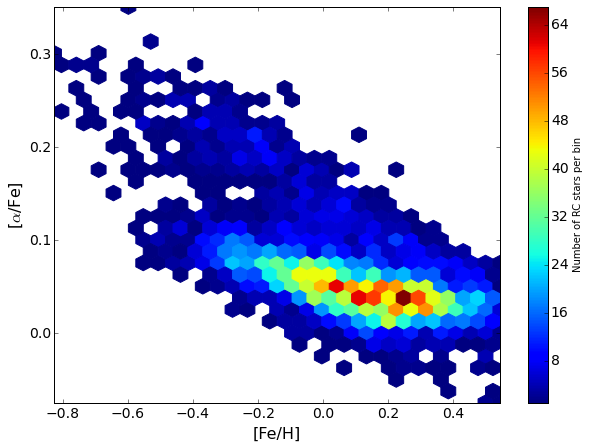

In [22]:
#define the spatial region of interest
spatial_mask = np.logical_and(allRC['RC_GALR']>6, allRC['RC_GALR']<8) & (np.abs(allRC['RC_GALZ'])<1.0)

RCannulus = allRC[spatial_mask]
plt.hexbin(RCannulus['METALS'], RCannulus['ALPHAFE'], gridsize=30, mincnt=1)

#'METALS' is technically [Z/H], but for our purposes, it is akin to [Fe/H]
plt.xlabel('[Fe/H]', fontsize=16)
plt.ylabel(r'[$\alpha$/Fe]', fontsize=16)
cb = plt.colorbar(label='Number of RC stars per bin')


## YOUR HELP NEEDED
If you've made it this far, THANK YOU. *Please* send me (Jon Bird) an email with any problems or suggestions you may have for the notebook. Also, could you vote on:

1) Is the tone of the notebook appropriate? I wanted to make it approachable for very junior grad students?

2) Would you like to see an example of an indivudal star spectrum and the ASPCAP model plotted over it?

THANK YOU!!!

###Finished! Cells below are notes/snippets for me until next week

## Individual Spectrum plotting

 Optional:

  + APOGEE module [[https://github.com/jobovy/apogee]] Jo Bovy has
    written an excellent python module designed to interact and
    manipulate APOGEE data. It simplifies many of the basic operations
    we will cover below and also provides more advanced tools for
    dealing with individual APOGEE spectra. Highly recommended!


In [ ]:
#### Option 2: `APOGEE`


#We refer the user to [[https://github.com/jobovy/apogee]] for
#  installation instuctions and assume you have a working install in the
#  remainder of the notebook.
os.environ['APOGEE_DATA'] = data_directory
os.environ['APOGEE_REDUX'] = 'v603' #DR12 reduction version

import apogee.tools.read as apread
allStar= apread.allStar()  #will automatically download if catalog not available
print ("AllStar file Loaded")


In [ ]:
## 12.2 `apogee`  option (if running the cell below, you must have SKIPPED the `pyfits` module option above)
os.environ['APOGEE_DATA'] = data_directory
os.environ['APOGEE_REDUX'] = 'v603' #DR12 reduction version

import apogee.tools.read as apread
allRC= apread.rcsample()  #will automatically download if catalog not available
print ("Red Clump catalog file Loaded")
